In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline, interp1d
from video_test import extract_frames
import os


In [2]:
class Colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'  # Resets the color to default


In [3]:
def getSobelXGradient(frame):
    sobelX = cv2.Sobel(frame, cv2.CV_64F, 1, 0)
    return sobelX

def getIntensityIndexOuterEdge(y_values):
    # print("Y values")
    # print(abs(y_values))
    x_values = np.arange(len(y_values))

    # Define the Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [max(y_values), np.argmax(y_values), 1]

    # Perform the curve fitting
    try:
        params, covariance = curve_fit(gaussian, x_values, y_values, p0=initial_guess, maxfev=10000)
    except RuntimeError as e:
        print(f"{Colors.FAIL}Curve fitting failed: {e}{Colors.ENDC}")
        return np.argmax(y_values)

    # Extract the fitted parameters
    fitted_amplitude, fitted_mean, fitted_stddev = params

    # Find the index closest to the mean
    closest_index = np.argmin(np.round(np.abs(x_values - fitted_mean)))
    # print("Closest index to the mean:", closest_index)

    # Plot the original data and the fitted Gaussian curve
    # plt.plot(x_values, y_values, 'b-', label='data')
    # plt.plot(x_values, gaussian(x_values, *params), 'r--', label='fit: mean=%5.3f' % fitted_mean)
    # plt.axvline(x=fitted_mean, color='g', linestyle='--', label='Mean (µ)')
    # plt.axvline(x=closest_index, color='m', linestyle='--', label='Closest Index')
    # plt.xlabel('Index')
    # plt.ylabel('Y-values')
    # plt.legend()
    # plt.show()
    return closest_index
def getIntensityIndexInnerEdge(y_values):
    y_values = -(y_values)
    # print("Y values")
    # print(abs(y_values))
    x_values = np.arange(len(y_values))

    # Define the Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [max(y_values), np.argmax(y_values), 1]

    # Perform the curve fitting
    try:
        params, covariance = curve_fit(gaussian, x_values, y_values, p0=initial_guess, maxfev=10000)
    except RuntimeError as e:
        print(f"{Colors.FAIL}Curve fitting failed: {e}{Colors.ENDC}")
        return np.argmax(y_values)

    # Extract the fitted parameters
    fitted_amplitude, fitted_mean, fitted_stddev = params

    # Find the index closest to the mean
    closest_index = np.argmin(np.round(np.abs(x_values - fitted_mean)))
    # print("Closest index to the mean:", closest_index)

    # Plot the original data and the fitted Gaussian curve
    # plt.plot(x_values, y_values, 'b-', label='data')
    # plt.plot(x_values, gaussian(x_values, *params), 'r--', label='fit: mean=%5.3f' % fitted_mean)
    # plt.axvline(x=fitted_mean, color='g', linestyle='--', label='Mean (µ)')
    # plt.axvline(x=closest_index, color='m', linestyle='--', label='Closest Index')
    # plt.xlabel('Index')
    # plt.ylabel('Y-values')
    # plt.legend()
    # plt.show()
    return closest_index



In [4]:
def split_groups_polynomial(values, threshold, degree=3):
    sorted_values = sorted(values)
    # sorted_values = values
    
    # Find the split point for the highest group
    split_index = len(sorted_values)
    # for i in range(1, len(sorted_values)):
    #     diff = (sorted_values[i] - sorted_values[i - 1])
    #     print(f"{Colors.OKBLUE}Difference between {sorted_values[i]} - {sorted_values[i-1]}{Colors.ENDC}: {diff}")
    #     if sorted_values[i] - sorted_values[i - 1] > threshold:
    #         split_index = i
    #         break
    for i in range(len(sorted_values) - 1, 0, -1):
        # print(f"{Colors.OKBLUE}Difference between {Colors.ENDC}")
        # print((sorted_values[i] - sorted_values[i - 1]))
        if sorted_values[i] - sorted_values[i - 1] > threshold:
            split_index = i
            break
    
    high_values = sorted_values[split_index:]
    
    group1 = []
    group2 = []
    high_values_set = set(high_values)
    used_high_values = set()
    
    for value in values:
        if value in high_values_set:
            group1.append(value)
            group2.append(None)
            used_high_values.add(value)
        else:
            group1.append(None)
            group2.append(value)
    
    known_indices = [i for i, x in enumerate(group1) if x is not None]
    known_values = [x for x in group1 if x is not None]
    
    poly_interp = np.poly1d(np.polyfit(known_indices, known_values, degree))
    interp_values = np.round(poly_interp(range(len(group1)))).astype(int)
    
    group1 = [interp_values[i] if x is None else x for i, x in enumerate(group1)]
    
    return group1, group2

In [5]:
def getReferenceLine(frame):
    edgeTrace = getSobelXGradient(frame)

    intensity = np.array([getIntensityIndex(i) for i in edgeTrace])
    # print(f"{Colors.OKGREEN}Intensity:{Colors.ENDC}")
    # print(intensity)


    # Append intensity to the list
    # referenceLine, pixelLine  = split_groups(intensity, 5)
    # print(f"{Colors.OKGREEN}Refernce Line (linear interpolation):{Colors.ENDC}")
    # print(referenceLine)
    referenceLine, pixelLine  = split_groups_polynomial(intensity, 5)
    # print(f"{Colors.OKGREEN}Refernce Line (Polynomial Interpolation):{Colors.ENDC}")
    # print(referenceLine)
    # referenceLine, pixelLine  = split_groups_spline(intensity, 5)
    # print(f"{Colors.OKGREEN}Refernce Line (Cubic Spline Interpolation):{Colors.ENDC}")
    # print(referenceLine)
    # referenceLine, pixelLine  = split_groups_nearest(intensity, 5)
    # print(f"{Colors.OKGREEN}Refernce Line (Nearest Neighbor Interpolation):{Colors.ENDC}")
    # print(referenceLine)
    # print(f"\n{Colors.OKGREEN}Pixel Line:{Colors.ENDC}")
    # print(pixelLine)
   
    # print(f"\n{Colors.OKGREEN}Pixel displacement:{Colors.ENDC}")
    # print(abs(intensity - referenceLine))

    depth_map = np.zeros(frame.shape)
    for i in range(frame.shape[0]):
        depth_map[i][referenceLine[i]] = abs(intensity[i] - referenceLine[i])
    
    return depth_map, referenceLine

In [6]:
def getIntrinsics(H, W, fov = 70.0):
    # Calculate the focal length
    f = W / (2 * np.tan(np.deg2rad(fov) / 2))
    # Calculate the intrinsic matrix
    K = np.array([[f, 0, W / 2], [0, f, H / 2], [0, 0, 1]])
    return K

def pixelToPoint(depthImage, cameraIntrinsic=None):
    height, width = depthImage.shape
    if cameraIntrinsic is None:
        cameraIntrinsic = getIntrinsics(height, width)
    
    # Create u, v meshgrid and precompute projection triangle ratios
    fx, fy = cameraIntrinsic[0, 0], cameraIntrinsic[1, 1]
    cx, cy = cameraIntrinsic[0, 2], cameraIntrinsic[1, 2]

    x = np.linespace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    u, v = np.meshgrid(x, y)

    x_over_z = (u - cx) / fx
    y_over_z = (v - cy) / fy

    # 3D Pythargoras re-arranged to solve for z
    z = depthImage / np.sqrt(x_over_z ** 2 + y_over_z ** 2 + 1)
    x = x_over_z * z
    y = y_over_z * z

    return x, y, z

def createPointCloud(frame, depth_map):
    height, width = frame.shape
    if cameraIntrincis is None:
        cameraIntrinsics = getIntrinsics(height, width)
    
    # depth_map = getReferenceLine(frame)
    

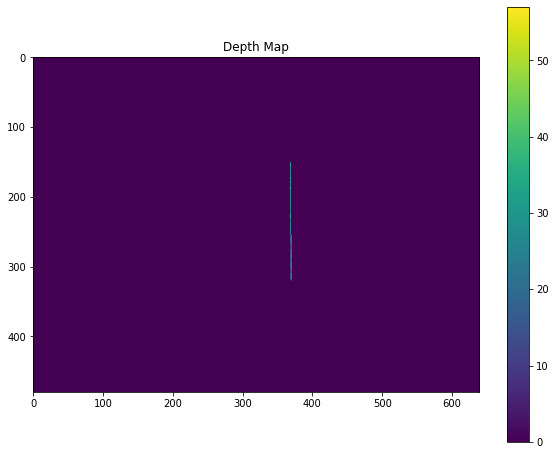

In [7]:
frame = cv2.imread("./video_frames/grey_step_8.94mm/frame_00003.jpg", cv2.IMREAD_GRAYSCALE)
depth_data = getReferenceLine(frame)

# depth_normalized = cv2.normalize(depth_data, None, 0, 50, cv2.NORM_MINMAX)
# depth_normalized = depth_normalized.astype(np.uint8)

# Visualize the depth map
plt.figure(figsize=(10, 8))
plt.imshow(depth_data)
plt.title('Depth Map')
plt.colorbar()
plt.show()

In [ ]:
# REFERENCE FRAME
objectName = "reference_03"
objectFrames = extract_frames(objectName, ".mp4")

mean_reference = []
count = 0

# Loop through the frames
for frame in objectFrames:
    # Get the Sobel X gradient
    # print(f"Processing frame {frame.shape}...")
    edgeTrace = getSobelXGradient(frame)

    # Calculate intensity index
    intensityInnerEdge = np.round(np.array([getIntensityIndexInnerEdge(i) for i in edgeTrace]))
    intensityOuterEdge = np.round(np.array([getIntensityIndexOuterEdge(i) for i in edgeTrace]))
    meanIndex = np.round((intensityInnerEdge + intensityOuterEdge) / 2)
    # print("Intensity Indices:")
    # print(intensity)

    # Convert the Sobel gradient image to absolute values to fit into the 8-bit range
    edgeTraceAbs = np.abs(edgeTrace).astype(np.uint8)
    
    # Convert the grayscale edgeTrace to BGR color image
    edgeTraceColor = cv2.cvtColor(edgeTraceAbs, cv2.COLOR_GRAY2BGR)

    # Define the output folder and create it if it doesn't exist
    output_folder = f'./edge_trace/{objectName}/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Plot the intensity points on the edgeTraceColor image
    for idx, val in enumerate(intensityInnerEdge):
        cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (255, 0, 0), -1)  # Blue dot with radius 1

    for idx, val in enumerate(intensityOuterEdge):
        cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 0, 255), -1)  # Red dot with radius 1

    for idx, val in enumerate(meanIndex):
        cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 255), -1)  # Red dot with radius 1

    # Save the image with the plotted points
    cv2.imwrite(f"./edge_trace/{objectName}/frame{count}.jpg", edgeTraceColor)
    mean_reference.append(meanIndex)
    print(f"{Colors.OKGREEN}Mean Index:{Colors.ENDC}")
    print(meanIndex)
    
    
    count += 1
    # break  # Remove this break to process all frames

# mean_reference = np.mean(mean_reference, axis=0)
# print(f"{Colors.OKGREEN}Mean Reference Indices:{Colors.ENDC}")
# print(mean_reference)
var_reference = np.var(mean_reference, axis=1)
print(f"{Colors.OKGREEN}Variance of Reference Indices:{Colors.ENDC}")
print(var_reference)

In [106]:
# Function definitions (extract_frames, getSobelXGradient, getIntensityIndex) should be provided or imported

# Define the object name and extract frames
objectName = "grey_step_3.68mm"
objectFrames = extract_frames(objectName, ".mp4")

meanPixelDisplacement = []
count = 0

heightList = []

# Loop through the frames
for frame in objectFrames:
    # Get the Sobel X gradient
    print(f"Processing frame {frame.shape}...")
    edgeTrace = getSobelXGradient(frame)

    # Calculate intensity index
    intensityInnerEdge = np.round(np.array([getIntensityIndexInnerEdge(i) for i in edgeTrace]))
    intensityOuterEdge = np.round(np.array([getIntensityIndexOuterEdge(i) for i in edgeTrace]))
    meanIndex = np.round((intensityInnerEdge + intensityOuterEdge) / 2)
    # print("Intensity Indices:")
    # print(intensity)

    # Convert the Sobel gradient image to absolute values to fit into the 8-bit range
    edgeTraceAbs = np.abs(edgeTrace).astype(np.uint8)
    
    # Convert the grayscale edgeTrace to BGR color image
    edgeTraceColor = cv2.cvtColor(edgeTraceAbs, cv2.COLOR_GRAY2BGR)

    # Define the output folder and create it if it doesn't exist
    output_folder = f'./edge_trace/{objectName}/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Plot the intensity points on the edgeTraceColor image
    # for idx, val in enumerate(intensityInnerEdge):
    #     cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (255, 0, 0), -1)  # Blue dot with radius 1

    # for idx, val in enumerate(intensityOuterEdge):
    #     cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 0, 255), -1)  # Red dot with radius 1

    # for idx, val in enumerate(meanIndex):
    #     cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 255), -1)  # Yellow dot with radius 1
    
    # print(f"{Colors.OKGREEN}Mean Index:{Colors.ENDC}")
    # print(meanIndex)
    referenceLine, _ = split_groups_polynomial(meanIndex, 10)
    # print(f"{Colors.OKGREEN}Reconstructed reference:{Colors.ENDC}")
    # print(referenceLine)

    # for idx, val in enumerate(referenceLine):
    #     cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 0), -1)  # Green dot with radius 1
    
    # Save the image with the plotted points
    # cv2.imwrite(f"./edge_trace/{objectName}/frame{count}.jpg", edgeTraceColor)
    
    pixelDisplacement = abs(meanIndex - referenceLine)
    c = 10.6276792
    s = pixelDisplacement / c
    heights = 80 * s / (37.3 + s)
    heights = [value for value in heights if value > 0]
    heightList.append(heights)
    

    count += 1
    # break  # Remove this break to process all frames

print(f"{Colors.OKGREEN}Heights:{Colors.ENDC}")
print(heights)
print(f"{Colors.OKGREEN}Mean Heights:{Colors.ENDC}")
print(f'{np.mean(heights)}')

Extracted 20 frames from the video.
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Processing frame (480, 640)...
Heights:
[4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250693464, 4.024796250

In [107]:
a = [3.979466608,
8.946196242,
14.03,
]

print(np.round(a, 2))

[ 3.98  8.95 14.03]
